In [1]:
%matplotlib widget

In [2]:
from ase.visualize import view

In [344]:
from genSTEM import ImageModel
#import cupy as cp
import numpy as np
cp = np
import matplotlib.pyplot as plt
from ase.io import read
from ase.build import make_supercell
atoms = read("0013687130_v6bxv2_tv0.1bxv0.0_d1.8z_traj.xyz")
atoms = make_supercell(atoms, np.diag((1,2,1)))
mask = atoms.positions[:,2] > 35
del atoms[mask]
atoms.rotate([1,0,0], (0,0,1))

from skimage.transform import warp
from matplotlib.transforms import Affine2D

In [4]:
atoms[1716].number = 60
atoms[1766].number = 60

In [337]:
%%time
jitter = 0

pixel_size = 0.3
drift_strength = 5e-4
drift_vector = [-1,0]
centre_drift = True

m0 = ImageModel(atoms, pixel_size=pixel_size, vacuum=10.,
                scan_rotation=0, centre_drift=centre_drift)
img0 = m0.generate_cupy()

m1 = ImageModel(atoms,  pixel_size=pixel_size, vacuum=10.,
                drift_strength=drift_strength, 
                drift_vector=drift_vector,
                jitter_strength=jitter, 
                scan_rotation=0, centre_drift=centre_drift)
img1 = m1.generate_cupy()

m2 = ImageModel(atoms,  pixel_size=pixel_size, vacuum=10.,
                jitter_strength=jitter, 
                drift_vector=drift_vector,
                drift_strength=drift_strength, 
                scan_rotation=90, centre_drift=centre_drift)
img2 = m2.generate_cupy()


Wall time: 7.83 s


In [338]:
#%%time
#img2 = cp.rot90(img2, 3)
side = np.minimum(*img1.shape)

img1 = img1[:side, :side]
img2 = img2[:side, :side]

In [339]:
I0, I1, I2 = img0, img1, img2

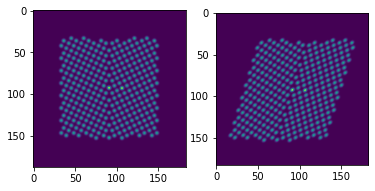

In [340]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(I0)
ax2.imshow(I1)

In [346]:
strengths = np.linspace(0, 0.03, 11)
angles = np.linspace(0, 360, 12, endpoint=False)
angles = np.deg2rad(angles)

def transform_from_angle_strength(angle,strength, angle_diff=np.pi/2):
    arr = np.zeros(np.shape(strength) + np.shape(angle) + (2,) + (3,3))
    if np.shape(strength):
        strength = strength[:, None, None]
    angle = np.column_stack([angle, angle])
    angle[:,1] = angle[:,1] + angle_diff
    arr[...] = np.eye(3)
    s_sin = strength*np.sin(angle)
    s_cos = strength*np.cos(angle)
    arr[..., 0,0] = 1 + s_cos
    arr[..., 0,1] = 10*s_cos
    arr[..., 0,2] = s_cos
    arr[..., 1,0] = -s_sin
    arr[..., 1,1] = 1 - 10*s_sin
    arr[..., 1,2] = -s_sin
    
    return arr.squeeze()

#T = transform_from_angle_strength(angles, strengths)
T = transform_from_angle_strength(0, 0.1)

#T = shift_rev @ T @ shift

In [347]:
T2 = Affine2D().translate(-shift_x, -shift_y) + Affine2D(T[1]) + Affine2D().translate(shift_x, shift_y)

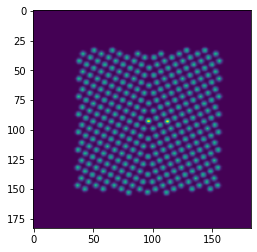

In [365]:
T = transform_from_angle_strength(0, 0.03)
T1 = Affine2D().translate(-shift_x, -shift_y) + Affine2D(T[0]) + Affine2D().translate(shift_x, shift_y)
I0b = warp(I1, np.linalg.inv(T1.get_matrix()))
plt.figure()
plt.imshow(I0b)

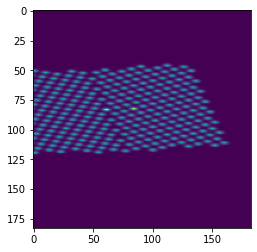

In [385]:
angle_diff = np.deg2rad(90)
T = transform_from_angle_strength(0, 0.05)
T2 = Affine2D().translate(-shift_x, -shift_y).rotate(angle_diff) + Affine2D(T[1]) + Affine2D().translate(shift_x, shift_y)
I2b = warp(I2, np.linalg.inv(T2.get_matrix()))
plt.figure()
plt.imshow(I2b)

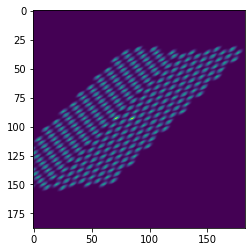

In [292]:
T2 = np.linalg.inv(T[:,:,0])
T2 = T2.reshape((-1, 3, 3))

T3 = np.linalg.inv(T[:,:,1])
T3 = T3.reshape((-1, 3, 3))

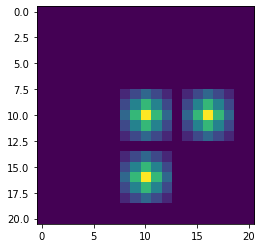

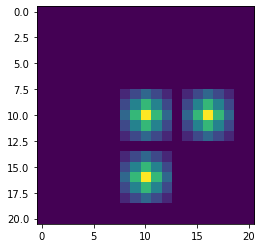

In [262]:
plt.figure()
plt.imshow(warp(I, np.linalg.inv(Affine2D().translate(-10, -10).scale(3,3).translate(10,10)), order=1))

plt.figure()
plt.imshow(warp(I, np.linalg.inv(
    Affine2D().translate(10, 10) 
    @ np.diag([3,3,1]) 
    @ Affine2D().translate(-10,-10)
), order=1))

In [ ]:

I = np.zeros((21, 21))
I[10,10] = 1
I[12, 10] = 1
I[10, 12] = 1

plt.figure()
plt.imshow(warp(I, Affine2D.shift()))

In [298]:
imgs1 = [warp(I1, t) for t in T2]
imgs1 = np.reshape(imgs1, (11, 12, 150, 150))


imgs2 = [warp(I2, t) for t in T3]
imgs2 = np.reshape(imgs2, (11, 12, 150, 150))


In [299]:
%matplotlib inline

In [300]:
# fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
# ax1.imshow(I0)
# ax2.imshow(I1)
# ax3.imshow(I2)

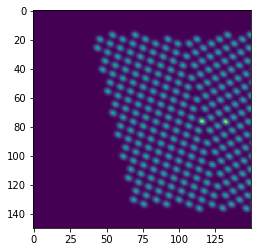

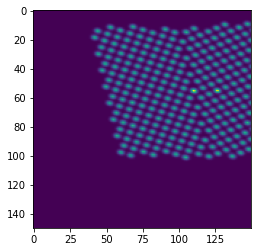

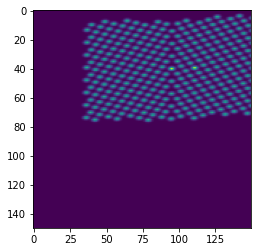

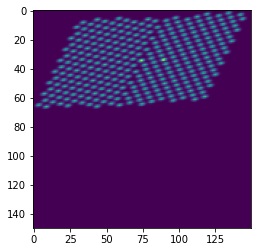

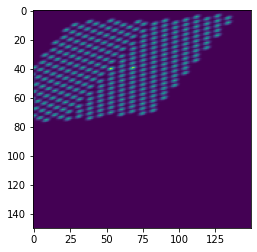

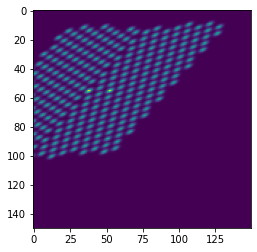

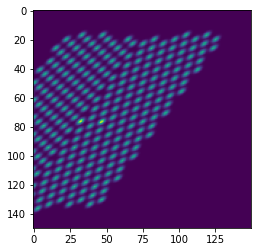

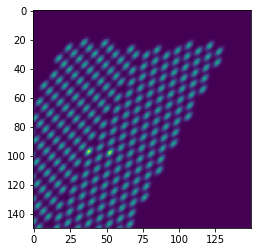

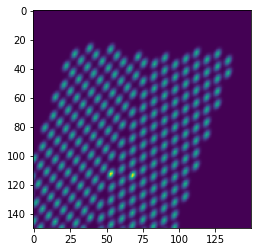

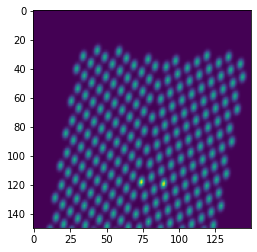

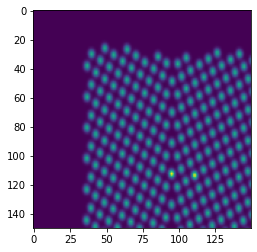

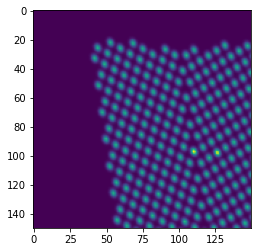

In [301]:
for i in range(12):
    plt.figure()
    plt.imshow(imgs[5, i])

In [273]:
w = img0.shape[0]

N = 21
strength = 30
scale = 1 + strength / w
shear = np.arctan(strength/w)

theta = np.deg2rad(np.linspace(0, 360, N))

scales = scale*np.sin(theta) + scale*np.cos(theta)
shears = shear*np.sin(theta + np.pi/4) + shear*np.cos(theta + np.pi/4)
shifts = np.array(img0.shape) / 2.0
shift = AffineTransform(translation=-shifts)
shift_inv = AffineTransform(translation=shifts)

angles = [0, -90]

for scale, shear in zip(scales, shears):

    rot_matrix = AffineTransform(rotation = angles[0])
    shear_matrix = AffineTransform(shear = shear)
    scale_matrix = AffineTransform(scale = (1, scale))

    warped = warp(img1,(shift + shear_matrix + scale_matrix + rot_matrix + shift_inv).inverse, order=0,)
    plt.figure()
    plt.imshow(warped)


#warped = warp(img1,(shift + shear_matrix + scale_matrix + rot_matrix + shift_inv).inverse, order=0,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:


tf_shift = AffineTransform(translation=[-shift_y, -shift_x])
tf_shift_inv = AffineTransform(translation=[shift_y, shift_x])
warped = warp(img,(tf_shift + shear_matrix + scale_matrix + rot_matrix + tf_shift_inv).inverse, order=0,)

In [49]:
from skimage.transform import AffineTransform
#from cupyx.scipy.ndimage import affine_transform
n = 1000
N = np.linspace(-n, n, 11)
w = img0.shape[0]
scales = 1 + N / w
shears = np.arctan(N/w)

shifts = np.array(img0.shape) / 2.0
shift = AffineTransform(translation=-shifts)
shift_inv = AffineTransform(translation=shifts)

def get_matrix(transform):
    return np.linalg.inv(transform.params)

transform1 = np.array(
    [get_matrix(shift + AffineTransform(shear=shear) + shift_inv) 
        for shear, scale in zip(shears, scales)])
transform1 = cp.array(transform1)

transform2 = np.array(
    [get_matrix(shift + AffineTransform(scale=scale) + shift_inv) 
        for shear, scale in zip(shears, scales)])
transform2 = cp.array(transform2)


In [50]:
def plot(imgs):
    imgs2 = []
    for img in imgs:
        img -= img.min()
        img /= img.max()
        img *= 255
        img = fromarray(img.astype("uint8"))
        imgs2.append(img)
    display(TwoByTwoLayout(imgs2))

In [51]:
from ipywidgets import TwoByTwoLayout, Output
from PIL.Image import fromarray

def plot(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    img = fromarray(img.astype("uint8"))
    display(img)

In [53]:
from ipywidgets import GridspecLayout

def subplots(imgs, ncols=2):
    nrows = int(np.ceil(len(imgs) / ncols))
    grid = GridspecLayout(nrows, ncols)
    for i in range(nrows):
        for j in range(ncols):
            index = i*nrows + j
            if index < len(imgs):
                o = Output()
                with o:
                    plot(imgs[index])
                grid[i, j] = o
                
subplots([I0, I1])

In [79]:
import sympy as sp
x, y, z, sx, sy, theta, shx, shy, tx, ty = sp.symbols("x, y, z, scale_x, scale_y, theta, shear_x, shear_y, trans_x, trans_y")

In [193]:
def sp_scale(sx, sy):
    tf = sp.eye(3)
    tf[0,0] = sx
    tf[1,1] = sy
    return tf

def sp_translate(tx, ty):
    tf = sp.eye(3)
    tf[0,2] = tx
    tf[1,2] = ty
    return tf

def sp_rotate(theta):
    tf = sp.eye(3)
    c, s = sp.cos(theta), sp.sin(theta)
    tf[0,0] = c
    tf[1,1] = c
    tf[0,1] = s
    tf[1,0] = -s
    return tf

def sp_shear(shear_x=0, shear_y=0):
    tf = sp.eye(3)
    tf[1,0] = shear_y
    tf[0,1] = shear_x
    return tf

In [194]:
A = sp_translate(tx, ty)
B = sp_scale(sx, sy)
C = sp_rotate(theta)
D = sp_shear(shx, shy)
E = sp_translate(-tx, -ty)


In [207]:
#F = A*B*C*E
F = E*C*B*A

In [208]:
func = sp.lambdify((sx, sy, theta, shx, shy, tx, ty), F, modules='numpy')

In [214]:
g = func(
    scale_x = 2, 
    scale_y = 1, 
    theta = 2.5,
    shear_x = 1,
    shear_y = 1,
    trans_x = shifts[1], 
    trans_y = shifts[0])

In [215]:
img2 = warp(img, np.linalg.inv(g))

In [218]:
a = AffineTransform(translation=shifts[::-1])
b = AffineTransform(scale=(2, 1))
c = AffineTransform(rotation=2)
d = AffineTransform(translation=-shifts[::-1])


In [219]:
a + b + c + d

<AffineTransform(matrix=
    [[  -0.83229367,   -0.90929743, -207.89257606],
     [   1.81859485,   -0.41614684,   26.64323419],
     [   0.        ,    0.        ,    1.        ]]) at 0x2467ac5fbc8>

In [ ]:
shears = 

In [54]:


def transform_scaling(scale_x=1, scale_y=1):
    tf = np.eye(3)
    tf[0,0] = scale_x
    tf[1,1] = scale_y
    return tf

def transform_rotation(clockwise_radians):
    tf = np.eye(3)
    c, s = np.cos(clockwise_radians), np.sin(clockwise_radians)
    tf[0,0] = c
    tf[1,1] = c
    tf[0,1] = s
    tf[1,0] = -s
    return tf

def transform_shear(shear_x=0, shear_y=0):
    tf = np.eye(3)
    tf[0,1] = shear_x
    tf[1,0] = shear_y
    return tf

def transform_translate(shift_x, shift_y):
    tf = np.eye(3)
    tf[0,2] = shift_x
    tf[1,2] = shift_y
    return tf


In [63]:
from scipy.misc import face

In [64]:
img = face(True)

In [65]:
from skimage.transform import warp
# https://stackabuse.com/affine-image-transformations-in-python-with-numpy-pillow-and-opencv/

In [74]:
x,y = np.array(img.shape)/2
arr = [transform_translate(y, x), transform_rotation(np.pi/2), transform_translate(-y, -x),]
#arr = np.linalg.inv(arr[0])
arr = np.linalg.inv(np.linalg.multi_dot(arr))

img2 = warp(img, arr)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(img)
ax2.imshow(img2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [59]:
x,y = np.array(img.shape)/2
arr = [transform_translate(x, y), transform_shear(np.pi/4), transform_translate(-x, -y),]
arr = np.linalg.inv(np.linalg.multi_dot(arr))

In [ ]:

shift + shear_matrix + scale_matrix + rot_matrix + shift_inv

In [60]:
# arr = [-transform_translate(x, y), transform_scaling(1), transform_translate(x, y),]
# arr2 = np.linalg.inv(np.linalg.multi_dot(arr))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [41]:
fig = plt.figure(figsize = (5, 20))
grid = plt.GridSpec(ncols=2, nrows = len(shears), figure=fig)
for row in range(len(shears)):
    ax1, ax2 = fig.add_subplot(grid[row, 0]), fig.add_subplot(grid[row, 1])
    ax1.imshow(affine_transform(img1, transform1[row]).get())
    ax2.imshow(affine_transform(img2, transform2[row]).get())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'affine_transform' is not defined

In [112]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.imshow(I0)
ax2.imshow(I1)
ax3.imshow(I2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [92]:
nrows = 5
ncols = 5
img = I1

shift_x, shift_y = np.array(img.shape) / 2.0
tf_shift = AffineTransform(translation=[-shift_y, -shift_x])
tf_shift_inv = AffineTransform(translation=[shift_y, shift_x])


fig, AX = plt.subplots(ncols=ncols, nrows=nrows, )
shears = np.linspace(-np.pi, np.pi, np.prod((ncols, nrows)))

for shear, ax in zip(shears, AX.flatten()):
    ax.imshow(warp(img, tf_shift + AffineTransform(shear=shear) + tf_shift_inv))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [55]:
shears

array([-3.14159265, -2.87979327, -2.61799388, -2.35619449, -2.0943951 ,
       -1.83259571, -1.57079633, -1.30899694, -1.04719755, -0.78539816,
       -0.52359878, -0.26179939,  0.        ,  0.26179939,  0.52359878,
        0.78539816,  1.04719755,  1.30899694,  1.57079633,  1.83259571,
        2.0943951 ,  2.35619449,  2.61799388,  2.87979327,  3.14159265])

In [20]:
from skimage.transform import AffineTransform, warp

shear_limits = 0.8
shear_step = 0.01
scale_limits = 0.8
scale_step = 0.01

import ipywidgets.widgets as w
SCALE = w.FloatSlider(value=1, min=-scale_limits + 1, max=scale_limits + 1, step=shear_step, description='Scale')
SHEAR = w.FloatSlider(value=0, min=-shear_limits, max=shear_limits, step=scale_step, description='Shear')
img = I2

o = w.Output()
def warpit(img):
    angle = 0
    rot_matrix = AffineTransform(rotation = np.deg2rad(-angle))
    shear_matrix = AffineTransform(shear = SHEAR.value,)
    scale_matrix = AffineTransform(scale = (1, SCALE.value))

    shift_x, shift_y = np.array(img.shape) / 2.0
    tf_shift = AffineTransform(translation=[-shift_y, -shift_x])
    tf_shift_inv = AffineTransform(translation=[shift_y, shift_x])
    warped = warp(img,(tf_shift + shear_matrix + scale_matrix + rot_matrix + tf_shift_inv).inverse, order=0,)
    return warped

fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.imshow(I1)
im = ax2.imshow(warpit(img))

def on_value_change(change):
    with o:
        new_img = warpit(img)
        im.set_data(new_img)
        im.autoscale()

SCALE.observe(on_value_change, names='value')
SHEAR.observe(on_value_change, names='value')
display(SCALE)
display(SHEAR)
display(o)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FloatSlider(value=1.0, description='Scale', max=1.8, min=0.19999999999999996, step=0.01)

FloatSlider(value=0.0, description='Shear', max=0.8, min=-0.8, step=0.01)

Output()

In [23]:
from PIL.Image import fromarray

In [46]:
def plot(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    img = fromarray(img.astype("uint8"))
    display(img)

In [48]:
o1 = Output()
o2 = Output()
with o1:
    plot(I1)
with o2:
    plot(I2)

In [53]:
from ipywidgets import Output, VBox, HBox, TwoByTwoLayout
TwoByTwoLayout(top_left=VBox((HBox((o1, o1)), HBox((o1, o1)))), top_right=o2)

TwoByTwoLayout(children=(VBox(children=(HBox(children=(Output(layout=Layout(grid_area='top-left'), outputs=({'…

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(img1.get())
ax2.imshow(img2.get())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
hamm = np.hamming(img1.shape[0])
window = hamm[:, None] * hamm

def hybrid_correlation(img1, img2, p=0.9, filter=True):
    if filter:
        hamm = cp.hamming(img1.shape[0])
        window = hamm[:, None] * hamm
        img1 = img1 * window
        img2 = img2 * window

    fftimg1 = cp.fft.fft2(img1)
    fftimg2 = cp.fft.fft2(img2)
    m = fftimg1 * cp.conj(fftimg2)
    corr =  cp.real(cp.fft.ifft2(cp.abs(m)**p * cp.exp(1j * cp.angle(m))))
    corr = cp.fft.fftshift(corr)
    translation = cp.array(cp.unravel_index(corr.argmax(), corr.shape))
    center = cp.array(corr.shape) // 2
    return tuple(x for x in translation - center)

def translate(img, shift):
    return cp.roll(img, shift, axis=(0,1))

In [84]:
img2b = translate(img2, hybrid_correlation(img1, img2))
plt.figure()
plt.imshow((img1 + img2b).get())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [78]:
I2 = img1.get()
I2 = img2.get()

In [24]:
from scipy.ndimage import fourier_shift

In [56]:
I1, I2 = img1.get(), img2.get()
I3 = np.fft.ifft2(fourier_shift(np.fft.fft2(I2), S)).real
I4 = np.roll(I2, S[0], axis=0)
I4 = np.roll(I4, S[1], axis=1)
I4 = np.roll(I2, S, axis=(0,1))
I5 = scipy.ndimage.shift(I2, S)

plt.figure()
plt.imshow(I1 + I4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [55]:
I4 = np.roll(I2, S, axis=(0,1))


In [29]:
plt.figure()
plt.imshow(I2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
corr = scipy.signal.correlate2d(img1.get(), img2.get())

In [237]:
plt.figure()
plt.imshow(window)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
window = 

In [13]:
data = np.random.random((300, 300))
%timeit np.real(np.fft.ifft(data))
%timeit np.fft.irfft(data)

957 µs ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.92 ms ± 84.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
from py4DSTEM.process.utils import get_maxima_2D

In [ ]:
get_maxima_2D()

In [19]:
# a = np.real(np.fft.ifft(data))
# b = np.fft.irfft(data)
# np.testing.assert_array_almost_equal(a, b)

In [15]:
a.shape

(300, 300)

In [16]:
b.shape

(300, 598)

In [5]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,10))
ax1.imshow(cp.asnumpy(img1))
ax2.imshow(cp.asnumpy(cp.rot90(img2, 3)))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
m.generate_cupy(jitt)